# **NB 6.2: Targeted Entitiy Sentiment Identification**

## Importing Libraries

In [1]:
import os
import requests
import re
import sys
import regex as re
import ast

In [2]:
import nltk as nltk
import nltk.corpus  
from nltk.text import Text

In [3]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Multiprocessing

#pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True )

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
# Imports the Google Cloud client library

from google.cloud import storage
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = "nlp_final_project_kshitijm"

# Creates the new bucket
bucket = storage_client.bucket(bucket_name)
print(f"Bucket {bucket.name} connected.")

Bucket nlp_final_project_kshitijm connected.


In [27]:
#Visuals

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

# %pip install wordcloud
from wordcloud import WordCloud
from IPython.display import display, HTML
sns.set_style("whitegrid")

In [31]:
# Task specific
from collections import Counter
from itertools import chain

## Importing Datasets

In [8]:
%%time
## Positive and Negative Sentiment Datasets

df_filt_pos=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7v3_POS_BERTopics_Sentiments_NER.csv',lineterminator='\n')
df_filt_neg=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7v4_NEG_BERTopics_Sentiments_NER.csv',lineterminator='\n')

CPU times: user 42.2 s, sys: 11.9 s, total: 54.1 s
Wall time: 2min 22s


### We will try to extract entities from docs which have a positive sentiment

In [16]:
def get_top_ents(df):

    df['ENT_ORG']=df['ENT_ORG'].parallel_apply(ast.literal_eval)
    org_list = list(chain.from_iterable(df['ENT_ORG']))
    counter_org = Counter(org_list)
    top_20_org = counter_org.most_common(20)
    
    df['ENT_PROD']=df['ENT_PROD'].parallel_apply(ast.literal_eval)
    prod_list = list(chain.from_iterable(df['ENT_PROD']))
    counter_prod = Counter(prod_list)
    top_20_prod = counter_prod.most_common(20)
    
    df['ENT_PER']=df['ENT_PER'].parallel_apply(ast.literal_eval)
    per_list = list(chain.from_iterable(df['ENT_PER']))
    counter_per = Counter(per_list)
    top_20_per = counter_per.most_common(20)
    
    df['ENT_NORP']=df['ENT_NORP'].parallel_apply(ast.literal_eval)
    norm_list = list(chain.from_iterable(df['ENT_NORP']))
    counter_norm = Counter(norm_list)
    top_20_norm = counter_norm.most_common(20)
    
    return top_20_org, top_20_prod, top_20_per, top_20_norm

In [17]:
%%time
top_20_org_pos, top_20_prod_pos, top_20_per_pos, top_20_norm_pos = get_top_ents(df_filt_pos)

CPU times: user 4.65 s, sys: 5.34 s, total: 9.99 s
Wall time: 11 s


In [18]:
POS_trend=pd.DataFrame({'ORGANIZATION':top_20_org_pos,'PRODUCT':top_20_prod_pos,'PERSON':top_20_per_pos, 'NORM':top_20_norm_pos})
POS_trend

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(AI, 78573)","(AI, 185906)","(Size, 2140)","(Chinese, 5935)"
1,"(Gray Media Group, 60661)","(AIdriven, 5053)","(Bing, 1887)","(European, 3026)"
2,"(ChatGPT, 29275)","(UsMeet, 2600)","(Greta Van, 1600)","(Canadian, 2659)"
3,"(Google, 23770)","(HPC, 1718)","(Elon Musk, 1561)","(American, 2109)"
4,"(Microsoft, 22937)","(Cresta, 1472)","(Biden, 1411)","(British, 1650)"
5,"(V19, 18860)","(Bing, 1435)","(Trump, 1258)","(Americans, 1401)"
6,"(Station20022022 Gray Television, 14059)","(V19, 1430)","(Standigm, 1250)","(French, 1268)"
7,"(ML, 13751)","(SE, 1271)","(Closefor, 1228)","(German, 1229)"
8,"(GR, 12167)","(CRM, 1263)","(CoFounder, 1181)","(Lunit, 1080)"
9,"(IBM, 12077)","(Google Cloud, 1115)","(Laivly, 1117)","(Korean, 992)"


* POS: ChatGPT, Microsoft, 
* POS: Google + Alphabet - Bard
* POS: Coinbase, Ethereum

In [19]:
%%time
top_20_org_neg, top_20_prod_neg, top_20_per_neg, top_20_norm_neg = get_top_ents(df_filt_neg)

CPU times: user 1.09 s, sys: 3.2 s, total: 4.29 s
Wall time: 4.76 s


In [20]:
NEG_trend=pd.DataFrame({'ORGANIZATION':top_20_org_neg,'PRODUCT':top_20_prod_neg,'PERSON':top_20_per_neg, 'NORM':top_20_norm_neg})
NEG_trend

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(AI, 9138)","(AI, 17956)","(Vectorspace AI, 1291)","(Chinese, 2073)"
1,"(ChatGPT, 9051)","(Bing, 680)","(Bing, 806)","(European, 651)"
2,"(Google, 8508)","(SE, 419)","(Elon Musk, 741)","(American, 601)"
3,"(Microsoft, 4565)","(SoundHound AI, 349)","(Musk, 724)","(Italian, 440)"
4,"(Googles, 2404)","(Coinbase, 309)","(Trump, 661)","(Canadian, 393)"
5,"(Bard, 2316)","(Matrix AI Networks, 173)","(Biden, 505)","(Canadians, 391)"
6,"(Matrix AI Network, 2256)","(AIdriven, 172)","(Ernie Bot, 496)","(Americans, 386)"
7,"(V19, 2011)","(XT, 167)","(Sundar Pichai, 440)","(British, 367)"
8,"(Facebook, 1744)","(JavaScript, 162)","(Gebru, 410)","(French, 320)"
9,"(OpenAI, 1660)","(Nebula AI, 143)","(Vectorspace, 346)","(German, 256)"


* NEG: Vectorspace AI - ML Based Blockchain
* NEG: Google + Alphabet - Bard
* NEG: Coinbase, Ethereum

----
### Looking at Entities from Topics with a positive sentiment

In [22]:
def get_top_ents_2(df):

    # df['ENT_ORG']=df['ENT_ORG'].parallel_apply(ast.literal_eval)
    org_list = list(chain.from_iterable(df['ENT_ORG']))
    counter_org = Counter(org_list)
    top_20_org = counter_org.most_common(20)
    
    # df['ENT_PROD']=df['ENT_PROD'].parallel_apply(ast.literal_eval)
    prod_list = list(chain.from_iterable(df['ENT_PROD']))
    counter_prod = Counter(prod_list)
    top_20_prod = counter_prod.most_common(20)
    
    # df['ENT_PER']=df['ENT_PER'].parallel_apply(ast.literal_eval)
    per_list = list(chain.from_iterable(df['ENT_PER']))
    counter_per = Counter(per_list)
    top_20_per = counter_per.most_common(20)
    
    # df['ENT_NORP']=df['ENT_NORP'].parallel_apply(ast.literal_eval)
    norm_list = list(chain.from_iterable(df['ENT_NORP']))
    counter_norm = Counter(norm_list)
    top_20_norm = counter_norm.most_common(20)
    
    ent_trend_df=pd.DataFrame({'ORGANIZATION':top_20_org,'PRODUCT':top_20_prod,'PERSON':top_20_per, 'NORM':top_20_norm})
    return ent_trend_df


In [87]:
def create_wordcloud(df,word_remove):
    org_list = list(chain.from_iterable(df['ENT_ORG']))
    prod_list = list(chain.from_iterable(df['ENT_PROD']))
    per_list = list(chain.from_iterable(df['ENT_PER']))
    norm_list = list(chain.from_iterable(df['ENT_NORP']))
    
    ent_list = org_list + prod_list + per_list + norm_list
    ent_list_cleaned = [word for word in ent_list if word not in word_remove]
    

    
    words= ' '.join(ent_list_cleaned)
    wordcloud = WordCloud(width=400, height=400, background_color='white', min_font_size=10, max_words=60).generate(words)
    
    plt.figure(figsize=(7, 7), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [21]:
# ConvAI
df_filt_pos_convai=df_filt_pos[df_filt_pos.Bert_topics==1]
df_filt_pos_convai.ENT_ORG.sample(2)
top_20_org_pos_convai, top_20_prod_pos_convai, top_20_per_pos_convai, top_20_norm_pos_convai = get_top_ents_2(df_filt_pos_convai)

In [23]:
POS_trend=pd.DataFrame({'ORGANIZATION':top_20_org_pos_convai,'PRODUCT':top_20_prod_pos_convai,'PERSON':top_20_per_pos_convai, 'NORM':top_20_norm_pos_convai})
POS_trend

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(ChatGPT, 7931)","(AI, 7524)","(Bing, 958)","(Chinese, 142)"
1,"(Microsoft, 4352)","(Bing, 670)","(Elon Musk, 504)","(Oracles, 91)"
2,"(AI, 3397)","(HPC, 474)","(Musk, 329)","(Canadian, 73)"
3,"(Google, 2744)","(Magellan AI, 401)","(Sam Altman, 243)","(American, 69)"
4,"(OpenAI, 2496)","(SageMaker, 244)","(Satya Nadella, 204)","(French, 68)"
5,"(IBM, 1390)","(Synopsys, 215)","(Pichai, 114)","(German, 66)"
6,"(Amazon, 983)","(Windows, 126)","(Sundar Pichai, 109)","(British, 61)"
7,"(Microsofts, 811)","(Core, 110)","(Altman, 107)","(European, 51)"
8,"(Gray Media Group, 765)","(Magellan, 89)","(Kyle Wiggers, 101)","(Italian, 42)"
9,"(Samsung, 574)","(Open AI, 89)","(Watson, 101)","(Canadians, 38)"


In [ ]:
# GREG BROCKMAN, SAM ALTMAN, SATYA NADELLA

In [27]:
# Healthcare
df_filt_pos_health=df_filt_pos[df_filt_pos.Bert_topics.isin([2])]
ent_trend_health = get_top_ents_2(df_filt_pos_health)
ent_trend_health

# ROCHE, BAYER, IBM
# DRUG DISCOVERY, APACHE KYLIN
# EUROPEAN COMPANIES 

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(AI, 3255)","(AI, 6519)","(Medipath, 494)","(European, 171)"
1,"(V19, 1541)","(AIdriven, 153)","(Size, 202)","(British, 111)"
2,"(GR, 1170)","(Galen, 139)","(Kylin Cloud, 136)","(Chinese, 99)"
3,"(Gray Media Group, 1071)","(Discovery, 117)","(Amarasingham, 120)","(American, 63)"
4,"(Artificial Intelligence, 991)","(V19, 113)","(Trump, 84)","(Canadian, 58)"
5,"(Healthcare, 906)","(L001, 95)","(Seth Koeppel, 71)","(Americans, 55)"
6,"(Roche, 894)","(CS, 77)","(Cyclica, 70)","(German, 48)"
7,"(Google, 814)","(Us2.ais, 73)","(Closefor, 67)","(Comperat, 41)"
8,"(healthcare, 568)","(Discovery Market, 60)","(Middle EastAfrica, 62)","(AidocThe, 36)"
9,"(IBM, 495)","(FDAcleared, 52)","(Ibex, 61)","(Irish, 32)"


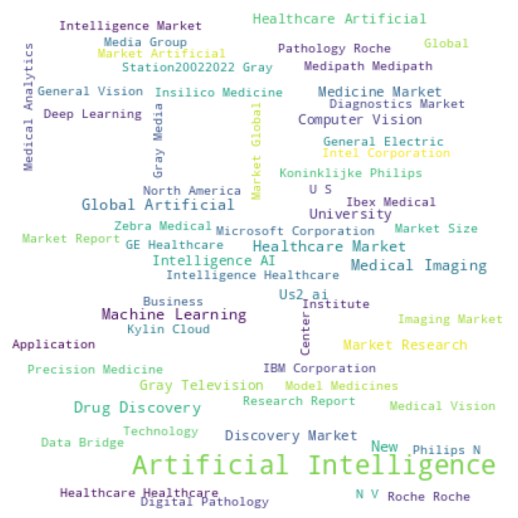

CPU times: user 2.22 s, sys: 263 ms, total: 2.48 s
Wall time: 2.06 s


In [79]:
%%time
word_remove_health=['AI','GR','V19','Gray Media Group','Artificial Intelligence','Artificial Intelligence AI','Artificial','Intelligence','Gray Media']
create_wordcloud(df_filt_pos_health,word_remove=word_remove_health)

In [29]:
# Financial
df_filt_pos_fin=df_filt_pos[df_filt_pos.Bert_topics.isin([3])]
ent_trend_fin = get_top_ents_2(df_filt_pos_fin)
ent_trend_fin

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(Matrix AI Network, 1681)","(AI, 3058)","(Guardforce AI, 242)","(Chinese, 264)"
1,"(AI, 1410)","(SoundHound AI, 519)","(Guardforce, 166)","(Canadian, 219)"
2,"(Lisk Machine Learning, 1204)","(SE, 353)","(N. Charles St, 137)","(Canadians, 180)"
3,"(Guardforce AI Co. Limited, 1097)","(Coinbase, 165)","(Syscoin SYS, 128)","(Polymath, 124)"
4,"(GFAI, 1043)","(Matrix AI Networks, 122)","(Biden, 128)","(American, 91)"
5,"(Renalytix AI, 959)","(AIdriven, 119)","(NAAQ, 123)","(European, 72)"
6,"(Ethereum, 911)","(XT, 99)","(XeniosCoin X, 113)","(Asian, 46)"
7,"(SE, 908)","(NA, 79)","(theresearch, 113)","(Houndify, 38)"
8,"(Decentralized Machine Learning, 608)","(Matrix AI, 58)","(Jim Cramer, 108)","(Americans, 34)"
9,(First Trust Nasdaq Artificial Intelligence an...,"(PrepCreate, 56)","(Censia, 108)","(German, 34)"


In [80]:
# ----------------
# HARDWARE
df_filt_pos_gpu=df_filt_pos[df_filt_pos.Bert_topics.isin([6])]
ent_trend_gpu = get_top_ents_2(df_filt_pos_gpu)
ent_trend_gpu

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(Nvidia, 2490)","(AI, 4313)","(Nvidias, 340)","(Chinese, 102)"
1,"(AI, 2002)","(HPC, 331)","(Supermicros, 213)","(topoftheline, 49)"
2,"(Supermicro, 1220)","(A100, 190)","(Huang, 156)","(Oracles, 44)"
3,"(Gray Media Group, 592)","(Rescale, 112)","(Jensen Huang, 155)","(North American, 27)"
4,"(Intel, 523)","(Core, 109)","(Charles Liang, 101)","(European, 24)"
5,"(GPU, 508)","(DGX Cloud, 86)","(Ian Buck, 64)","(A100, 20)"
6,"(Microsoft, 408)","(Tensor Core, 83)","(Picasso, 58)","(American, 16)"
7,"(ChatGPT, 363)","(AI Enterprise, 71)","(highbandwidth, 57)","(Canadian, 14)"
8,"(Nvidias, 320)","(AIdriven, 53)","(Manuvir Das, 55)","(Linux, 14)"
9,"(GR, 300)","(Universal GPU Platform, 49)","(Justin Boitano, 48)","(German, 14)"


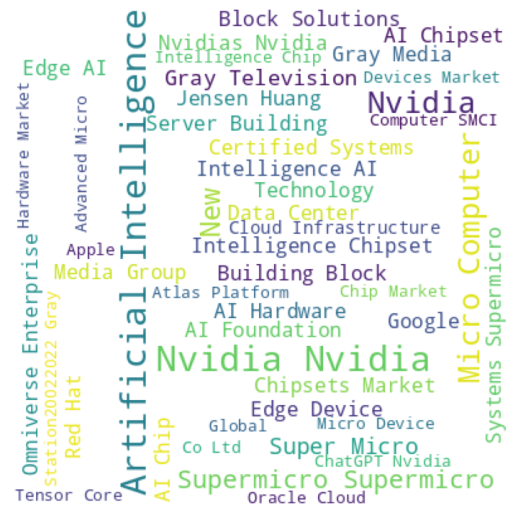

In [82]:
word_remove_gpu=['AI','GR','V19','Gray Media Group','Artificial Intelligence','Artificial Intelligence AI','Artificial','Intelligence','Gray Media','AI Enterprise','Gray Television']
create_wordcloud(df_filt_pos_gpu,word_remove=word_remove_gpu)

In [ ]:
# HPC - High Performance Computing: NEW INDUSTRY
# NVIDIA, Intel
# NVIDIA DGX
# NVIDIA - Jensen Huang, Ian Buck, Manuvir Das

In [83]:
# LEGAL
df_filt_pos_legal=df_filt_pos[df_filt_pos.Bert_topics.isin([10])]
ent_trend_legal = get_top_ents_2(df_filt_pos_legal)
ent_trend_legal

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(AI, 1173)","(AI, 2259)","(CoCounsel, 577)","(Flyreel, 196)"
1,"(Gray Media Group, 658)","(UsMeet, 44)","(Everlaw, 202)","(Epiqs, 24)"
2,"(Deloitte, 450)","(Root, 42)","(Metaphysic, 198)","(Casetexts, 23)"
3,"(Casetext, 397)","(CoCounsels, 36)","(EvolutionIQ, 142)","(Americans, 21)"
4,"(Styldod, 373)","(AIdriven, 34)","(Thomas Salama, 72)","(Ukrainian, 19)"
5,"(Deloittes, 289)","(Tractables, 30)","(Ediscovery, 69)","(Han, 18)"
6,"(Legal AI Software, 225)","(Ediscovery Platform Skip, 30)","(Ian, 56)","(agoWith, 17)"
7,"(DTTL, 208)","(Tractables AI, 28)","(Sam Head, 54)","(Sabah, 14)"
8,"(Venture MLS, 199)","(Tn, 20)","(Salama, 54)","(Chinese, 13)"
9,"(S Scientific, 191)","(7M, 18)","(Bourne, 54)","(American, 13)"


In [ ]:
# Casetext
# Deloittes
# Everlaw
# Dan Helfrich

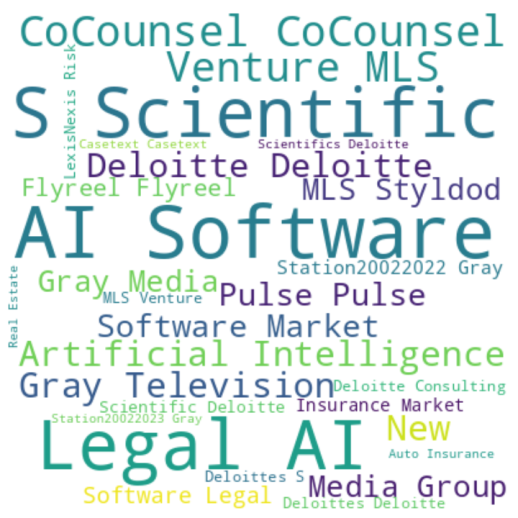

In [89]:
word_remove_legal=['AI','GR','V19','Gray Media Group','Artificial Intelligence','Artificial Intelligence AI','Artificial','Intelligence','Gray Media','AI Enterprise','Gray Television']
create_wordcloud(df_filt_pos_legal,word_remove=word_remove_legal)

In [90]:
# music
df_filt_pos_mus=df_filt_pos[df_filt_pos.Bert_topics.isin([13])]
ent_trend_mus = get_top_ents_2(df_filt_pos_mus)
ent_trend_mus

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(Gray Media Group, 587)","(AI, 1375)","(Musicubes, 152)","(Songtradrs, 102)"
1,"(Verbits, 498)","(Verbit, 442)","(Metaphysic, 95)","(Jaxsta, 51)"
2,"(Pro Music Rights, 483)","(Google Cloud, 43)","(Huang Mingxing, 72)","(Songtradr, 51)"
3,"(AI, 438)","(VI, 33)","(Biden, 68)","(visitSONGTRADR, 49)"
4,"(TikTok, 425)","(Galaxy, 27)","(Tom Livne, 56)","(Chinese, 24)"
5,"(Music Licensing, 308)","(D 101 million, 27)","(Tori, 56)","(French, 21)"
6,"(Google, 271)","(Open AI, 22)","(Emad Mostaque, 55)","(Sonantic, 17)"
7,"(Verbit, 226)","(SoundCloud, 18)","(Robert Schwartz, 54)","(tier1, 16)"
8,"(ByteDance, 223)","(UsMeet, 17)","(Paul Wiltshire, 51)","(German, 13)"
9,"(Musicube, 211)","(User Management Pack, 16)","(David Hoga, 51)","(Canadian, 13)"


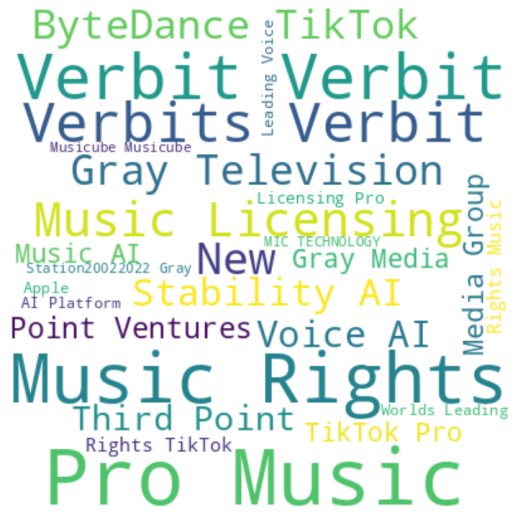

In [91]:
word_remove_music=['AI','GR','V19','Gray Media Group','Artificial Intelligence','Artificial Intelligence AI','Artificial','Intelligence','Gray Media','AI Enterprise','Gray Television']
create_wordcloud(df_filt_pos_mus,word_remove=word_remove_music)

----
## Now checking on Negative topics sentiments

In [33]:
# CRYPTOGRAPHY
df_filt_neg_crypto=df_filt_neg[df_filt_neg.Bert_topics.isin([0])]
ent_trend_cryto = get_top_ents_2(df_filt_neg_crypto)
ent_trend_cryto

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(Matrix AI Network, 1640)","(Coinbase, 218)","(Vectorspace AI, 979)","(Polymath, 118)"
1,"(Lisk Machine Learning, 1223)","(SE, 210)","(Vectorspace, 272)","(Chinese, 118)"
2,"(Ethereum, 1128)","(AI, 169)","(loweragainst, 139)","(Canadian, 45)"
3,"(Decentralized Machine Learning, 812)","(Nebula AI, 123)","(Syscoin SYS, 123)","(Canadians, 42)"
4,"(Link Machine Learning, 622)","(Matrix AI Networks, 120)","(XeniosCoin X, 102)","(PREVIO, 30)"
5,"(CryptoBeat, 508)","(AccountNow, 80)","(Bytom BTM, 101)","(Ethfinex, 22)"
6,"(NewsUpdates, 497)","(XT, 73)","(ChangeChange, 80)","(Enegra, 14)"
7,"(Machine Learning, 434)","(Stellar, 60)","(Dai DAI, 73)","(0.0148, 9)"
8,"(Facebook Share, 416)","(Matrix AI, 59)","(FilingsDaily RatingsNews, 64)","(Democrats, 8)"
9,"(LinkedIn Share, 416)","(CoinBene, 33)","(RequiredMail, 64)","(British, 7)"


In [34]:
# BARD
df_filt_neg_bard=df_filt_neg[df_filt_neg.Bert_topics.isin([1])]
ent_trend_bard = get_top_ents_2(df_filt_neg_bard)
ent_trend_bard

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(Google, 2274)","(AI, 1138)","(Bing, 273)","(European, 56)"
1,"(Microsoft, 897)","(Bing, 223)","(Sundar Pichai, 138)","(Chinese, 26)"
2,"(ChatGPT, 884)","(marketin, 27)","(Bard, 121)","(American, 15)"
3,"(Bard, 844)","(Windows, 18)","(Gebru, 104)","(Italian, 11)"
4,"(Googles, 774)","(Windows 11, 17)","(Pichai, 83)","(Asian, 9)"
5,"(AI, 428)","(ChatGPTstyle, 13)","(JWST, 74)","(Republican, 9)"
6,"(Microsofts, 398)","(MX, 12)","(Dean, 66)","(Republicans, 9)"
7,"(Alphabet, 361)","(AIdriven, 11)","(Mitchell, 49)","(Americans, 9)"
8,"(OpenAI, 189)","(ChatGPTstyle AI, 11)","(Timnit Gebru, 42)","(German, 9)"
9,"(Reuters, 160)","(Bing AI, 10)","(val, 33)","(Accentures, 8)"


In [35]:
# PERSONAL ASSISTANT
df_filt_neg_snap=df_filt_neg[df_filt_neg.Bert_topics.isin([5])]
ent_trend_snap = get_top_ents_2(df_filt_neg_snap)
ent_trend_snap

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(ChatGPT, 605)","(AI, 329)","(Snapchat, 105)","(ChatGPTthe, 32)"
1,(the Google Privacy Notice and Terms of Servic...,"(GardenFashion, 53)","(Bryn Hargreaves, 33)","(British, 27)"
2,"(AI, 138)","(ReadPhoto , 35)","(botis, 32)","(American, 17)"
3,"(Snapchat, 132)","(ChatGPT, 33)","(Dennis MortonPublished 20th, 31)","(Snapchats, 12)"
4,"(Google, 96)","(Snapchats, 31)","(SportWhats OnWhats OnArts, 29)","(Americans, 6)"
5,"(OpenAI, 81)","(AdOne Snapchat, 19)","(usersBy Ayaan AliPublished, 29)","(Democratic, 6)"
6,"(Independent Press Standards Organisation, 62)","(BlueMail, 14)","(Nina Warhurst, 25)","(Ukrainian, 5)"
7,"(SettingsTerms, 62)","(My AI, 11)","(PopularMy AI, 25)","(SITESEnglish, 4)"
8,"(Facebook, 59)","(GardenFashion and NoticesFree, 7)","(Boris Johnson, 24)","(Muslim, 3)"
9,"(JobPlace, 55)","(ReadPhoto Links UsSubmit, 6)","(Kang, 20)","(ITVNeighbours, 3)"


In [36]:
# JOBS
df_filt_neg_jobs=df_filt_neg[df_filt_neg.Bert_topics.isin([8])]
ent_trend_jobs = get_top_ents_2(df_filt_neg_jobs)
ent_trend_jobs

,ORGANIZATION,PRODUCT,PERSON,NORM
0,"(AI, 323)","(AI, 390)","(Goodfellow, 18)","(Apples, 23)"
1,"(ChatGPT, 79)","(callcenter, 5)","(Ian Goodfellow, 16)","(Chinese, 20)"
2,"(Apple, 68)","(Citrix, 5)","(Harry, 15)","(American, 15)"
3,"(Google, 66)","(Checkout, 5)","(Meghan, 13)","(Americans, 11)"
4,"(Microsoft, 36)","(Grammy, 5)","(Kristen Clarke, 12)","(British, 8)"
5,"(Amazon, 36)","(SingularityT AI, 5)","(ParentRe, 11)","(European, 7)"
6,"(V19, 34)","(SingularityT, 5)","(inperson, 10)","(Muslims, 5)"
7,"(TUC, 33)","(Newsource, 4)","(Adam, 9)","(Aussie, 5)"
8,"(Data Science, 30)","(JavaScript, 3)","(Biden, 9)","(Spanish, 4)"
9,"(IBM, 22)","(AI Can Fill the Jobs GapThats, 3)","(Elon Musk, 9)","(Asian, 4)"
